histogram jako wykres słupkowy do zaimplementowania,
wyrownanie do zaimplementowania (histogram equalization)


filtracja dolnoprzepustowaą gausa i rownomierną
oraz nieliniową (medianową) - to w notatniku z poprzednich labów mam :)


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage import io

In [41]:
# wczytanie obrazu i normalizacja do przedziału 0-1

image = color.rgb2gray(io.imread("xray.jpg"))
normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image))
image = normalize(image)

In [ ]:
# stworzenie histogramu wbudowaną w np funkcją

no_bins = 100
np_histogram, bins = np.histogram(image, bins=no_bins)

print(bins)
print(bins.shape)
print(np_histogram.shape)

plt.figure(dpi=100)
plt.imshow(image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.figure(dpi=80)
plt.plot(bins[:-1], np_histogram, "r*-")
plt.grid(True)

plt.show()

In [ ]:
# stworzenie dystrybuanty obrazu

distr = np.cumsum(np_histogram)
plt.figure()
plt.plot(distr, "g*")
plt.show()

In [ ]:
# przygotowanie funkcji zwracającej histogram i biny

def our_histogram(image, bins=3):
  # preparing bins
  our_bins = np.zeros(bins)
  pixel_values = image.flatten()
  diff = (np.max(pixel_values) - np.min(pixel_values))
  one_section = diff / bins
  for i in range(bins):
    our_bins[i] = np.min(pixel_values) + i * one_section
  our_bins = np.append(our_bins, np.max(pixel_values))
  # preparing histogram
  histogram = np.zeros(bins)
  for value in pixel_values:
    for bin_index in range(bins):
      if value >= our_bins[bin_index] and value < our_bins[bin_index+1]:
        histogram[bin_index] += 1
  our_bins = our_bins + one_section/2
  our_bins = np.delete(our_bins, -1)
  return histogram, our_bins

# histogram by Marek W.
"""
def our_histogram(image, bins=25):
  unique, unique_counts = np.unique(image, return_counts=True)
  histogram = np.zeros(bins)
  our_bins = np.zeros(bins+1)

  min_value, max_value = image.min(), image.max()
  diff = max_value - min_value

  for i in range(bins):
    start, end = min_value + i*diff/bins, min_value + (i+1)*diff/bins
    temp_counts = unique_counts[np.logical_and(unique >= start, unique < end)]
    histogram[i] = np.sum(temp_counts)
    our_bins[i] = start
  our_bins[-1] = end
  return histogram, our_bins """

In [ ]:
# użycie funkcji

no_bins = 15
our_histogram, bins = our_histogram(image, bins=no_bins)

print(bins)
print(bins.shape)
print(our_histogram.shape)

In [ ]:
# wyświetlenie obrazu

plt.figure(dpi=200)
plt.imshow(image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

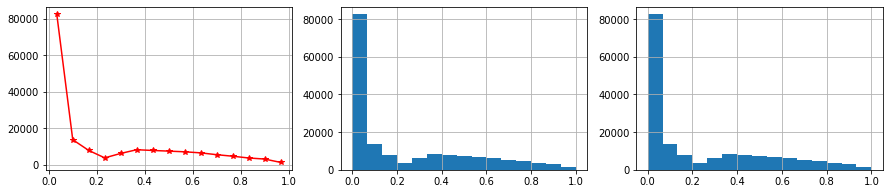

In [47]:
# stowrzenie histogramu jako wykresu słupkowego

plt.figure(figsize=(15,3))

plt.subplot(1,3,1)
plt.plot(bins[:], our_histogram, "r*-")
plt.grid(True)

plt.subplot(1,3,2)
plt.bar(bins, our_histogram, width=bins[0]*2)
plt.grid(True)

plt.subplot(1,3,3)
plt.hist(image.flatten(), bins=15)
plt.grid(True)
plt.show()

In [48]:
# implementacja dopasowania histogramu

def histogram_matching(source, target):
  # Wyznaczyc histogramy obu obrazow (moga byc idealne)
  source_values, bins, source_counts = np.unique(source.flatten(), return_counts=True, return_inverse=True)
  target_values, target_counts = np.unique(target.flatten(), return_counts=True)
  # Policzyc dystrybunaty dla obu histogramow
  source_distr = np.cumsum(source_counts, dtype=np.float64)
  target_distr = np.cumsum(target_counts, dtype=np.float64)
  # Dokonac interpolacji jednej dystrybuanty wykorzystujac druga dyst~
  matched_values = np.interp(source_distr, target_distr, target_values)
  plt.subplot(1,3,1)
  plt.plot(source_distr)
  plt.subplot(1,3,2)
  plt.plot(target_distr)
  plt.subplot(1,3,3)
  plt.plot(matched_values)
  # Wykorzystujac histogram odpowiednio go zaindeksowac i dokonac reshapu
  matched_image = matched_values[bins].reshape(source.shape)
  return matched_image

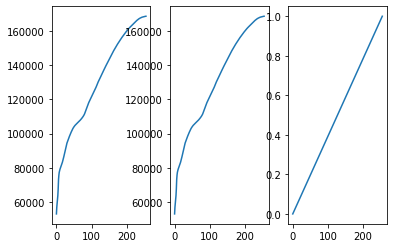

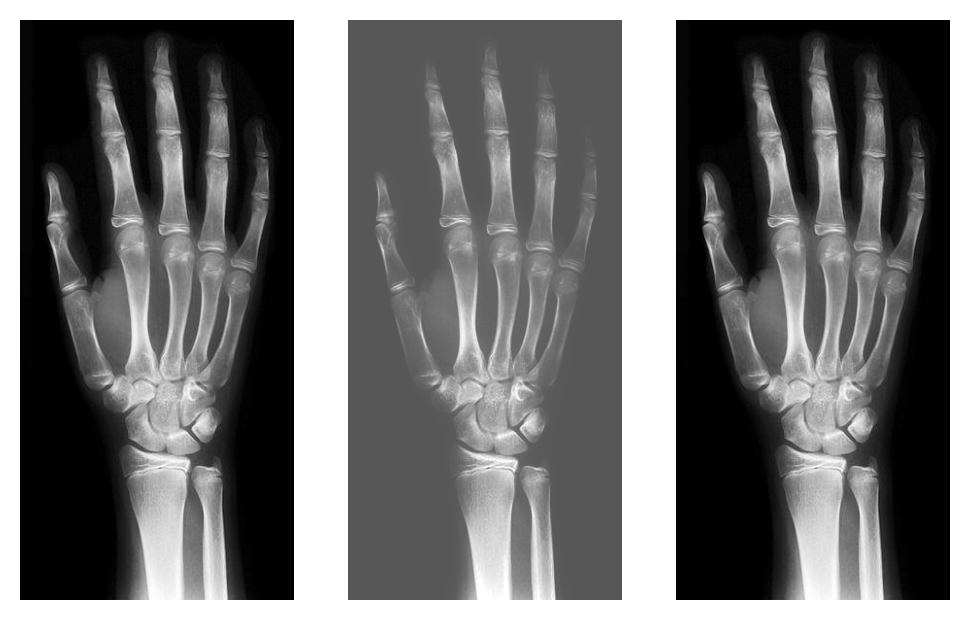

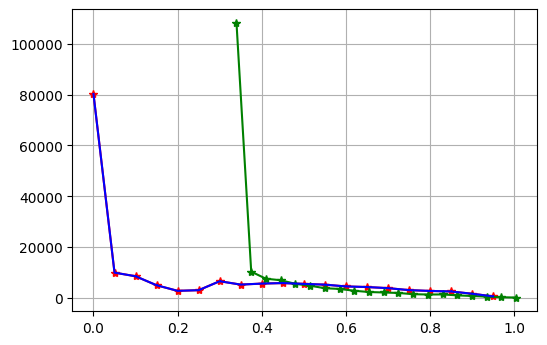

In [50]:
new_image = 0.7*image**2.3 + 0.34

# matched_image = normalize(new_image)
matched_image = histogram_matching(new_image, image)

plt.figure(dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(new_image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(matched_image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')


no_bins = 20
hist, bins = np.histogram(image, no_bins)
new_hist, new_bins = np.histogram(new_image, no_bins)
matched_hist, matched_bins = np.histogram(matched_image, no_bins)

plt.figure(dpi=100)
plt.plot(bins[:-1], hist, "r*-")
plt.plot(new_bins[:-1], new_hist, "g*-")
plt.plot(matched_bins[:-1], matched_hist, "b,-")
plt.grid(True)

plt.show()

In [51]:
# wczytanie obrazu i normalizacja do wartości 0-255

img = color.rgb2gray(io.imread("to_equalize.jpg"))
normalize = lambda image: ((image - np.min(image)) / (np.max(image) - np.min(image))) * 255
img = normalize(img)

In [ ]:
plt.figure(dpi=100)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

img = img.astype('uint8')

print(np.min(img))
print(np.max(img))

In [55]:
# wyrownanie - iplementacja

def histogram_equalization(src_img):
  histogram, bins = np.histogram(src_img.ravel(), bins=256)
  cs = np.cumsum(histogram) 
  nj = (cs - cs.min()) * 255
  N = cs.max() - cs.min()
  cs = nj / N
  cs = cs.astype('uint8')
  equalized_image= cs[src_img.ravel()].reshape(src_img.shape)
  return equalized_image

In [ ]:
img_after_eq = histogram_equalization(img)

plt.figure(dpi=100)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.figure(dpi=100)
plt.imshow(img_after_eq, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

In [ ]:
# sprawdzenie działania na innym obrazku

image = color.rgb2gray(io.imread("xray.jpg"))
image = normalize(image)
image = image.astype('uint8')

img_after_eq_xray = histogram_equalization(image)

f, axarr = plt.subplots(1,2, dpi=120)
axarr[0].imshow(image, cmap='gray', vmin=0, vmax=255)
axarr[0].axis('off')
axarr[1].imshow(img_after_eq_xray, cmap='gray', vmin=0, vmax=255)
plt.axis('off')


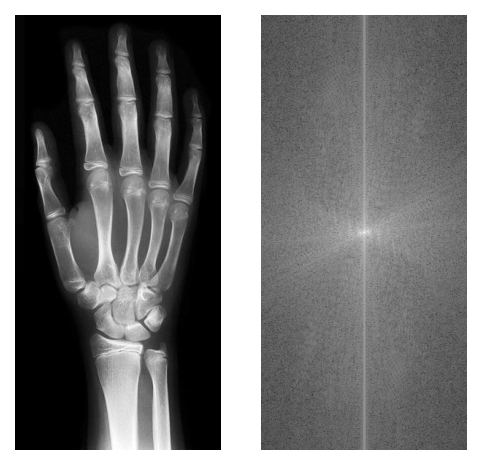

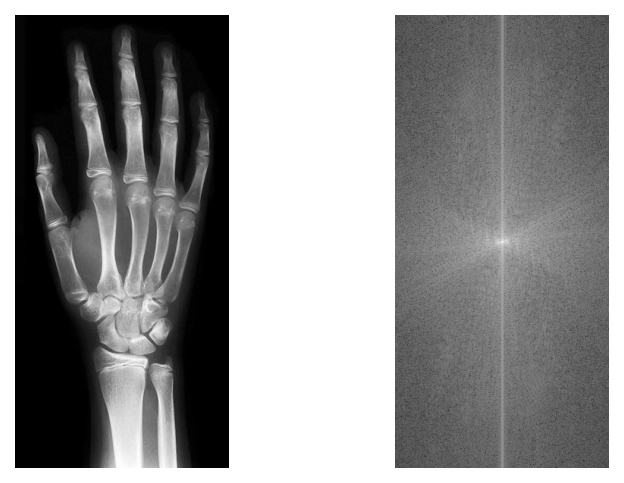

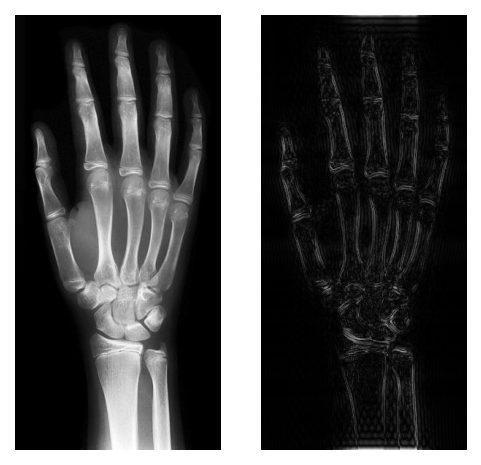

In [65]:
import numpy as np
import scipy.ndimage as nd

image = color.rgb2gray(io.imread("xray.jpg"))
normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image))
image = normalize(image)

image_fft = np.fft.fft2(image)
image_fft = np.fft.fftshift(image_fft)
magnitude = 20*np.log(np.abs(image_fft))

idft = np.abs(np.fft.ifft2(np.fft.ifftshift(magnitude/20)))


plt.figure(dpi=150)
plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(magnitude, cmap='gray')
plt.axis('off')
#plt.subplot(1,3,3)
#plt.imshow(idft, cmap='gray')
#plt.axis('off')
#plt.show()

f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(image, cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.axis('off')
plt.show()

rows, cols = image.shape
crow,ccol = rows//2 , cols//2
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.figure(dpi=150)
plt.subplot(131),plt.imshow(image, cmap = 'gray')
plt.axis('off')
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.axis('off')

plt.show()

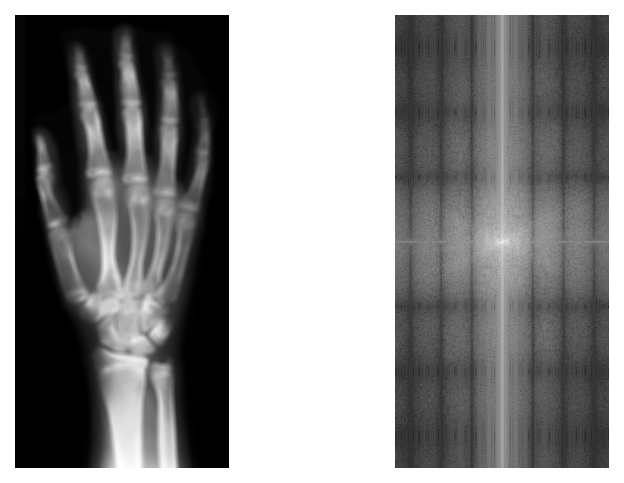

In [63]:
f = np.fft.fft2(nd.uniform_filter(image, 7))
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(nd.uniform_filter(image, 7), cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.axis('off')
plt.show()

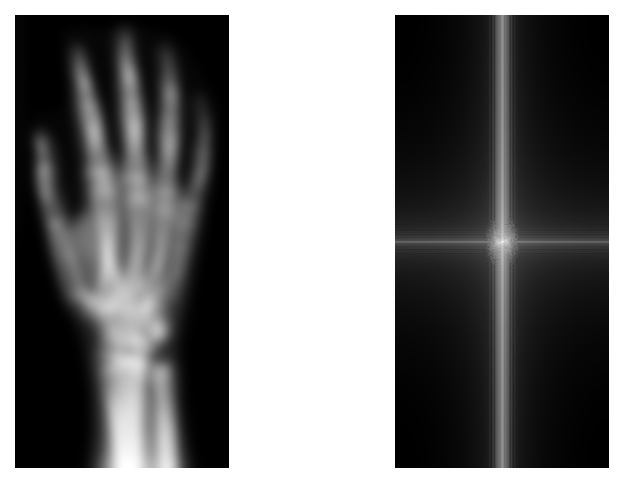

In [64]:
f = np.fft.fft2(nd.gaussian_filter(image, 7))
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(nd.gaussian_filter(image, 7), cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.axis('off')
plt.show()

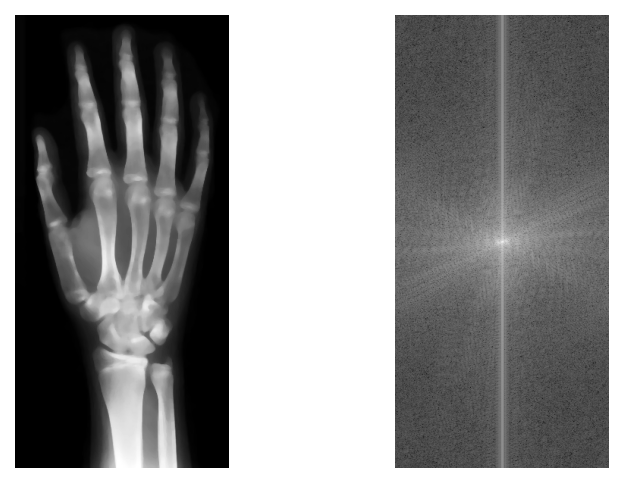

In [66]:
f = np.fft.fft2(nd.median_filter(image, 7))
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(nd.median_filter(image, 7), cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.axis('off')
plt.show()